In [1]:
# simclr_train.py
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from simclr_functions import CIFAR10Pair, SimCLR, plot_results, train_simclr, LinModel, train_linear_probe, get_lr, visualize_original_and_augmented_set, visualize_original_and_augmented
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt

# --- Configuration ---
class Config:
    dataset = "cifar10"
    data_dir = "./data"
    backbone = "resnet18"
    projection_dim = 128
    batch_size = 512
    simclr_epochs = 100
    learning_rate = 0.6
    weight_decay = 1e-6
    temperature = 0.5
    finetune_epochs = 100
    log_interval = 1

args = Config()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(
        size=(32, 32),
        scale=(0.7, 1.0),
        ratio=(0.75, 1.0),
        interpolation=InterpolationMode.BICUBIC,
        antialias=True
    ),
    transforms.RandomApply(
        [transforms.ColorJitter(
            brightness=(0.8, 1.2),
            contrast=(0.8, 1.2),
            saturation=(0.8, 1.2),
            hue=(-0.1, 0.1)
        )],
        p=0.7 
    ),
    transforms.RandomGrayscale(p=0.3),
    # transforms.GaussianBlur(),
    # transforms.RandomApply(
    #     [transforms.Lambda(lambda x: transforms.functional.solarize(x))],
    #     p=0.1 
    # ),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.228, 0.224, 0.225]),
    # transforms.RandomErasing(
    #     p=0.5,
    #     scale=(0.02, 0.05),  # Площадь 4x4 на изображении CIFAR-10 (32x32)
    #     ratio=(1.0, 1.0),  # Удерживаем квадратную форму
    #     value=0  # Заполняем черным цветом
    # )
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.228, 0.224, 0.225])
])

train_set = CIFAR10Pair(root=args.data_dir, train=True, transform=train_transform, download=True)
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)


Files already downloaded and verified


In [3]:

base_encoder = resnet18
model = SimCLR(base_encoder, projection_dim=args.projection_dim).to(device)

optimizer = SGD(model.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=args.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=lambda step: get_lr(step, args.simclr_epochs * len(train_loader), args.learning_rate, 1e-4))

train_loss_simclr = train_simclr(model, train_loader, optimizer, scheduler, device, args.simclr_epochs)
torch.save(model.state_dict(), f"./simclr_tr2_{args.simclr_epochs}.pt")


c:\Users\sever\OneDrive\Рабочий стол\Homework2\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\Homework2\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 98/98 [00:45<00:00,  2.14it/s]
INFO:simclr_functions:Epoch 1, Avg Loss: 5.7463
100%|██████████| 98/98 [00:44<00:00,  2.21it/s]
INFO:simclr_functions:Epoch 2, Avg Loss: 5.3945
100%|██████████| 98/98 [00:44<00:00,  2.20it/s]
INFO:simclr_functions:Epoch 3, Avg Loss: 5.2882
100%|██████████| 98/98 [00:44<00:00,  2.21it/s]
INFO:simclr_functions:Epoch 4, Avg Loss: 5.2254
100%|██████████| 98/98 [00:45<00:00,  2.18it/

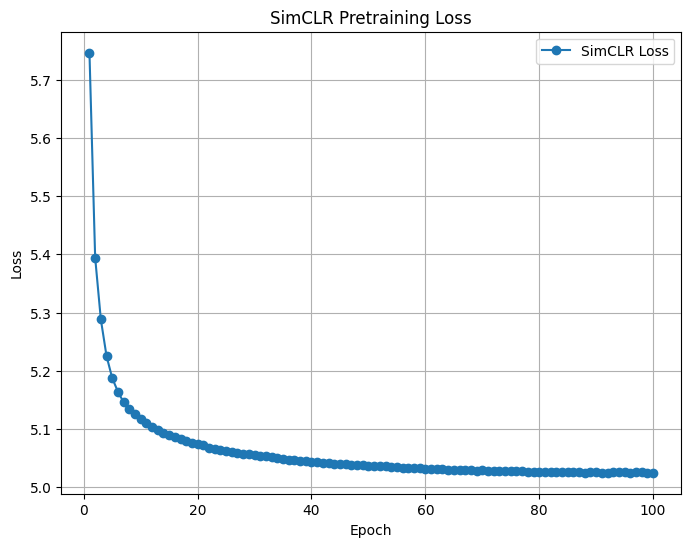

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, args.simclr_epochs + 1), train_loss_simclr, label="SimCLR Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimCLR Pretraining Loss")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Linear Probe
train_set_single = CIFAR10(root=args.data_dir, train=True, transform=train_transform, download=False)
test_set_single = CIFAR10(root=args.data_dir, train=False, transform=test_transform, download=False)
train_loader_single = DataLoader(train_set_single, batch_size=args.batch_size, shuffle=True)
test_loader_single = DataLoader(test_set_single, batch_size=args.batch_size, shuffle=False)

for param in model.enc.parameters():
    param.requires_grad = False

lin_model = LinModel(model.enc, model.feature_dim).to(device)
lin_model = LinModel(model.enc, model.feature_dim).to(device)
optimizer = torch.optim.SGD(
        lin_model.parameters(),
        0.2,   
        momentum=0.9,
        weight_decay=0.,
        nesterov=True)
scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr( 
        step,
        args.finetune_epochs * len(train_loader),
        args.learning_rate, 
        1e-4))

train_losses, test_losses, train_accuracies, test_accuracies = train_linear_probe(
    lin_model, train_loader_single, test_loader_single, optimizer, scheduler, device, args.finetune_epochs
)


100%|██████████| 98/98 [00:21<00:00,  4.46it/s]
INFO:simclr_functions:Epoch 1, Train Acc: 0.6175, Test Acc: 0.6312
100%|██████████| 98/98 [00:22<00:00,  4.40it/s]
INFO:simclr_functions:Epoch 2, Train Acc: 0.6478, Test Acc: 0.6664
100%|██████████| 98/98 [00:22<00:00,  4.45it/s]
INFO:simclr_functions:Epoch 3, Train Acc: 0.6614, Test Acc: 0.6611
100%|██████████| 98/98 [00:21<00:00,  4.55it/s]
INFO:simclr_functions:Epoch 4, Train Acc: 0.6662, Test Acc: 0.6565
100%|██████████| 98/98 [00:21<00:00,  4.53it/s]
INFO:simclr_functions:Epoch 5, Train Acc: 0.6689, Test Acc: 0.6687
100%|██████████| 98/98 [00:21<00:00,  4.54it/s]
INFO:simclr_functions:Epoch 6, Train Acc: 0.6757, Test Acc: 0.6735
100%|██████████| 98/98 [00:22<00:00,  4.43it/s]
INFO:simclr_functions:Epoch 7, Train Acc: 0.6750, Test Acc: 0.6846
100%|██████████| 98/98 [00:22<00:00,  4.26it/s]
INFO:simclr_functions:Epoch 8, Train Acc: 0.6803, Test Acc: 0.6677
100%|██████████| 98/98 [00:22<00:00,  4.32it/s]
INFO:simclr_functions:Epoch 9, T

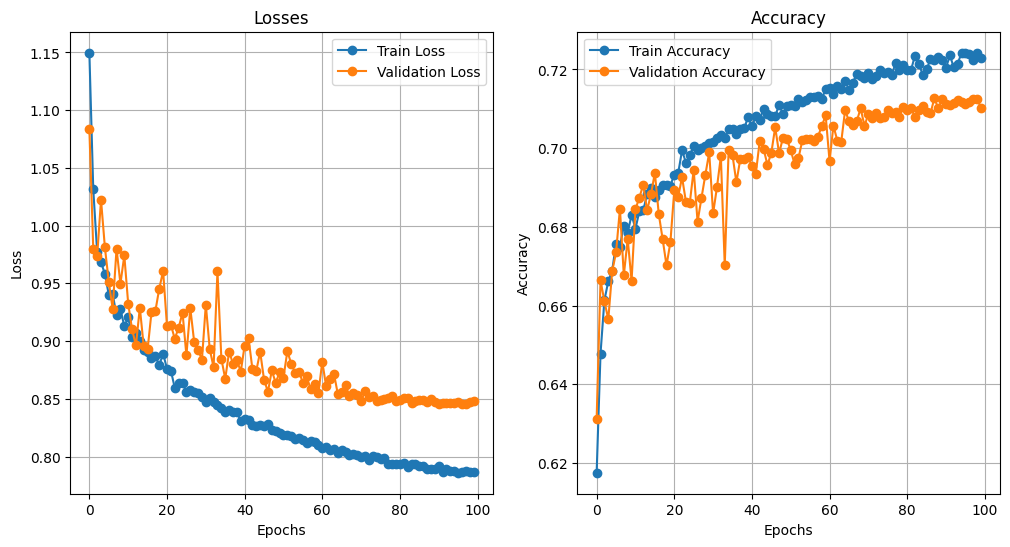

In [7]:
plot_results(train_losses, test_losses, train_accuracies, test_accuracies)

In [8]:
import pickle

data_to_save = {
    "train_loss_simclr": train_loss_simclr,
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accuracies": train_accuracies,
    "test_accuracies": test_accuracies,
}

with open(f"simclr_tr2_{args.simclr_epochs}_metrics.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

print("Training results saved to training_results.pkl")


Training results saved to training_results.pkl
